Simulating differential pointing
====

This notebook treats about the simulation of differential pointing between same pair detectors using two different approaches. 

In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np
from copy import deepcopy

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import modify_beam_offsets

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x
    
# gets rid of warning when plotting beams
np.seterr(divide='ignore',invalid='ignore')   

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

The flow is the following: sky + instrument + scanning strategy --> map2tod --> perturb beam centroids --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Part 1 lectures. 

In [2]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=1.0, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 2048
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Let's inject differential pointing between 
two pixel-pair bolometers in our data!
The model is the following:
* Draw from a normal distribution G(mu, sigma) the magnitudes of the differential pointing rho.
* Draw from a uniform distribution U(0, 2pi) the directions of the differential pointing theta.
* Move the position of bottom bolometers as
     - x_top/bottom = \pm rho / 2 * cos(theta)
     - y_top/bottom = \pm rho / 2 * sin(theta)
     
et voilà!

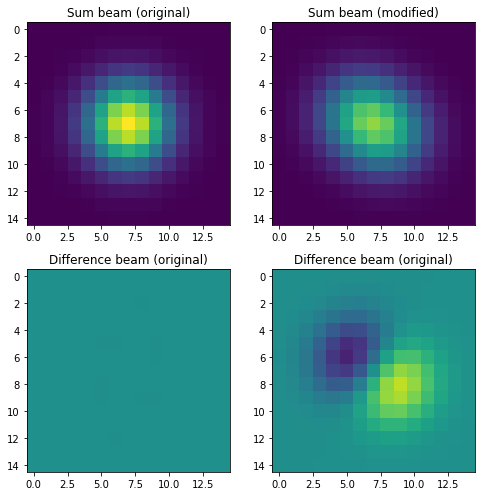

In [3]:
## For visualisation purposes only we keep a copy
## of the initial position
inst_mod = deepcopy(inst)

## Inject quarter-beam differential pointing (exaggerated!)
inst_mod.beam_model.xpos, inst_mod.beam_model.ypos = \
    modify_beam_offsets(inst_mod.beam_model.xpos, 
                        inst_mod.beam_model.ypos,
                        mu_diffpointing=30., 
                        sigma_diffpointing=15., 
                        seed=5847)

## Let's have a look at our beam parameters now
## Let's plot the resulting beam map for a pixel in the focal plane
summap_original, diffmap_original = construct_beammap(
    inst.beam_model, ct=0, cb=1, nx=15, 
    pix_size=0.2 / 180. * np.pi / 60.)
summap_modified, diffmap_modified = construct_beammap(
    inst_mod.beam_model, ct=0, cb=1, nx=15, 
    pix_size=0.2 / 180. * np.pi / 60.)

fig, ax = pl.subplots(2,2, figsize=(7, 7))

ax[0, 0].imshow(summap_original, vmin=0, vmax=1)
ax[0, 0].set_title('Sum beam (original)')
ax[0, 1].imshow(summap_modified, vmin=0, vmax=1)
ax[0, 1].set_title('Sum beam (modified)')

ax[1, 0].imshow(diffmap_original, vmin=-0.4, vmax=0.4)
ax[1, 0].set_title('Difference beam (original)')
ax[1, 1].imshow(diffmap_modified, vmin=-0.4, vmax=0.4)
ax[1, 1].set_title('Difference beam (original)')
pl.tight_layout()
pl.show()

Let's now generate our TOD from our input sky, instrument, and scanning strategy We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation). We will also inject instrument noise in time-domain.
Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 20 deg at a resolution nside = 2048. We also show the residual map at each step alongside with the hit count map.

Pixels outside patch boundaries. Your output map will be cropped. To avoid this, increase the parameter width while initialising the TOD.


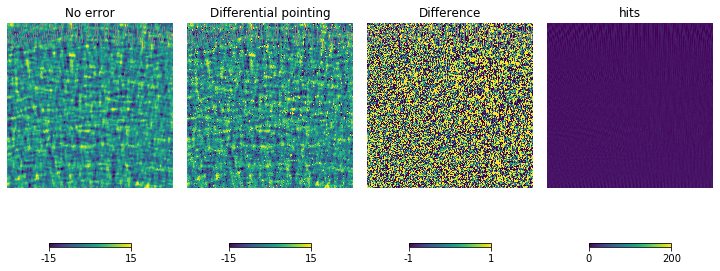

<Figure size 432x288 with 0 Axes>

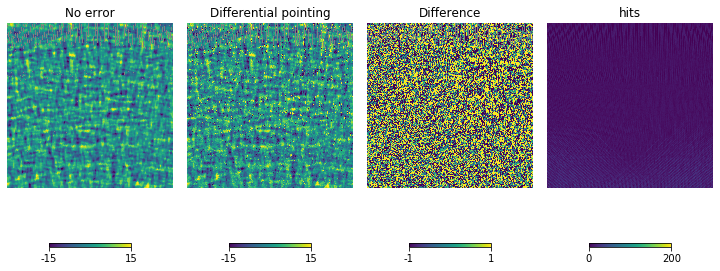

<Figure size 432x288 with 0 Axes>

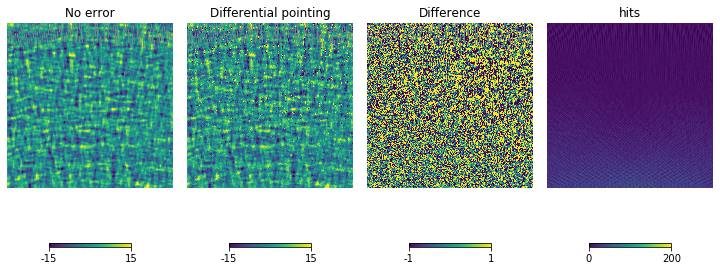

<Figure size 432x288 with 0 Axes>

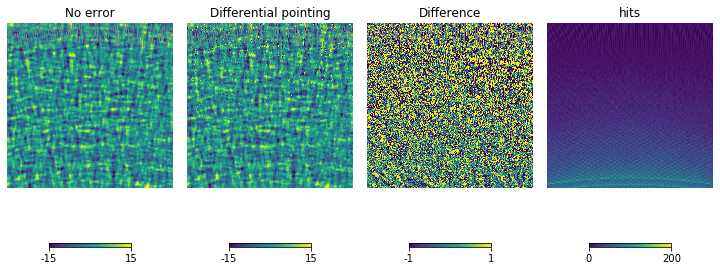

<Figure size 432x288 with 0 Axes>

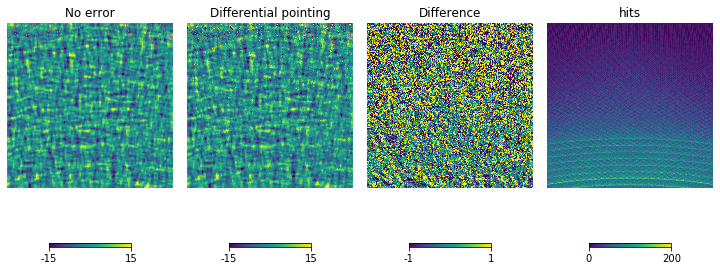

<Figure size 432x288 with 0 Axes>

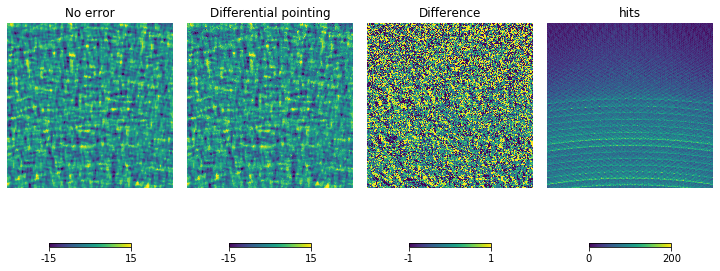

<Figure size 432x288 with 0 Axes>

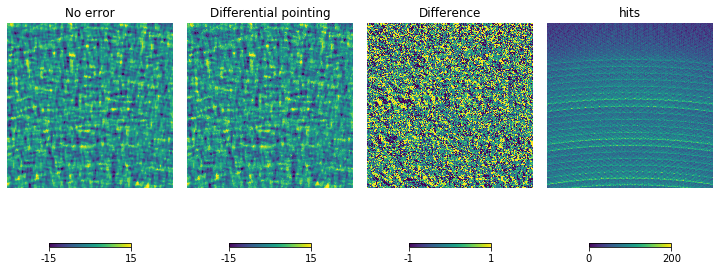

<Figure size 432x288 with 0 Axes>

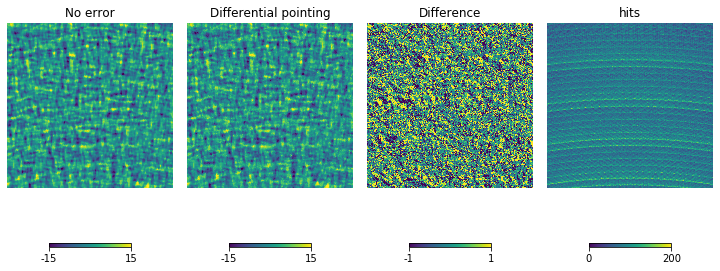

<Figure size 432x288 with 0 Axes>

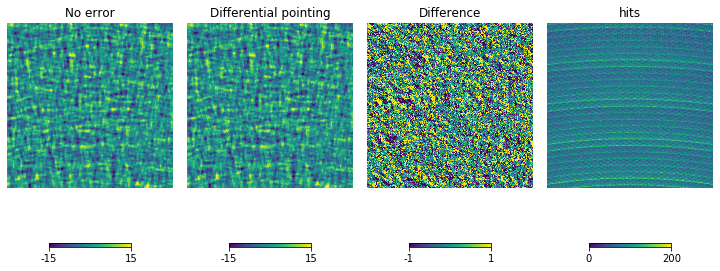

<Figure size 432x288 with 0 Axes>

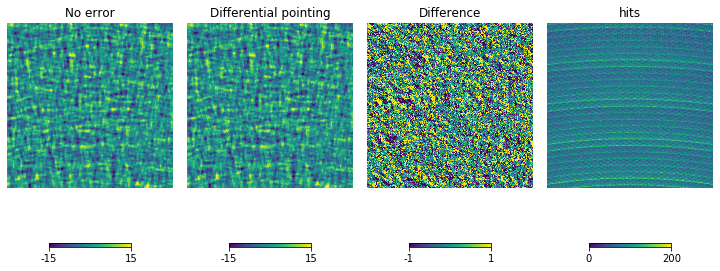

<Figure size 432x288 with 0 Axes>

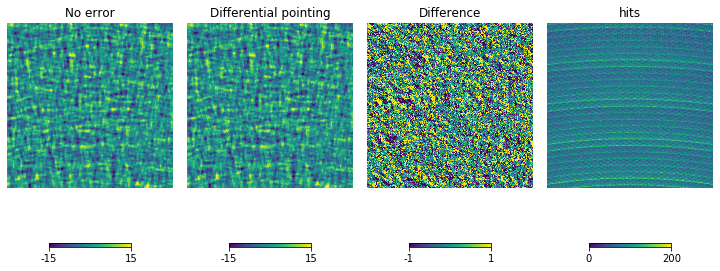

<Figure size 432x288 with 0 Axes>

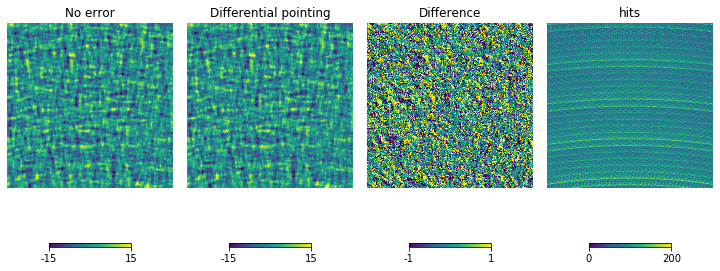

<Figure size 432x288 with 0 Axes>

In [4]:
## Loop over CESs: noiseless simulations
## For visualisation purposes, we reconstruct both with and without systematics
histograms = []
xsize = 330
reso = 1.7

for CESnumber in range(scan.nces):
    tod_mod = TimeOrderedDataPairDiff(
        inst_mod, scan, sky_in, 
        CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=20.,
        array_noise_level=None,
        array_noise_seed=None,
        mapping_perpair=False)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_out_tot_mod = OutputSkyMap(
            projection=tod_mod.projection, 
            nside=tod_mod.nside_out, 
            obspix=tod_mod.obspix)
        
    ## Scan input map to get TODs
    d_mod = np.array(
        [tod_mod.map2tod(det) for det in tqdm(
                range(inst.focal_plane.nbolometer))])
    
    ## Project TOD to maps
    tod_mod.tod2map(d_mod, sky_out_tot_mod)
    
    ## Plot Stokes Q maps at each step
    nhit = partial2full(
        sky_out_tot_mod.nhit, 
        sky_out_tot_mod.obspix, 
        sky_out_tot_mod.nside, 
        fill_with=0.0)
    
    sky_out = sky_in.Q + 0.0
    
    sky_out_mod = partial2full(
        (sky_out_tot_mod.get_QU())[0], 
        sky_out_tot_mod.obspix, 
        sky_out_tot_mod.nside, 
        fill_with=0.0)
    
    mask = nhit < 3
    sky_out[mask] = np.nan
    sky_out_mod[mask] = np.nan
    
    fig = pl.figure(figsize=(10, 10))
    
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=reso, sub=141, 
                title='No error', notext=True, min=-15, max=15)
    hp.gnomview(sky_out_mod, rot=[0, -57.5], xsize=xsize, reso=reso, sub=142, 
                title='Differential pointing', notext=True, min=-15, max=15)
    hp.gnomview(sky_out_mod - sky_out, rot=[0, -57.5], 
                xsize=xsize, reso=reso, sub=143, 
                title='Difference', notext=True, min=-1, max=1)
    hp.gnomview(nhit, rot=[0, -57.5], xsize=xsize, reso=reso, sub=144, 
                title='hits', notext=True, min=0, max=200)
    pl.show()
    
    h, b, _ = pl.hist(
        (sky_out_mod[~mask] - sky_out[~mask])/np.sqrt(nhit[~mask]), 
        bins=50, histtype='step', 
        lw=2, range=[-5, 5])
    
    histograms.append(h)
    pl.clf()


Let's have a look at the pre-whitened residual in intensity, that is dI/sqrt(nhit).
The residual decreases as we add more scans, i.e. the effect averages down:

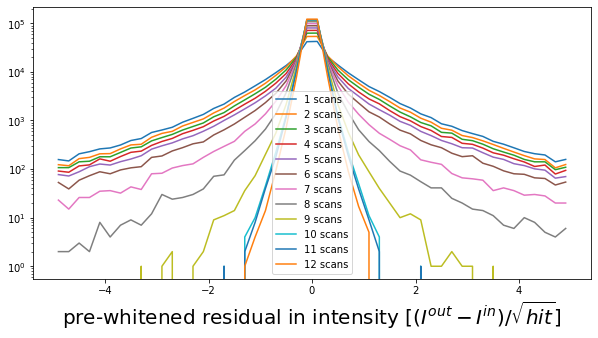

In [5]:
fig = pl.figure(figsize=(10, 5))

for pos, h in enumerate(histograms):
    pl.plot(b[:-1] + np.diff(b)/2, h, label='{} scans'.format(pos + 1))
pl.legend()
pl.xlabel('pre-whitened residual in intensity [($I^{out} - I^{in} $)/$\sqrt{hit}$]', fontsize=20)
pl.yscale('log')
pl.show()

A zoom on the position of 4 pairs of bolometers in the focal plane is shown below. When bolometers are displaced, we always compute the pointing for the mapmaking step (tod2maps) to be performed with respect of the mean pointing of the pair (cyan). As the displacement is symmetric for the two pairs the original position of the bolometers coincides with the pair center after the bolometer position is perturbed (cyand and black curves do overlap).

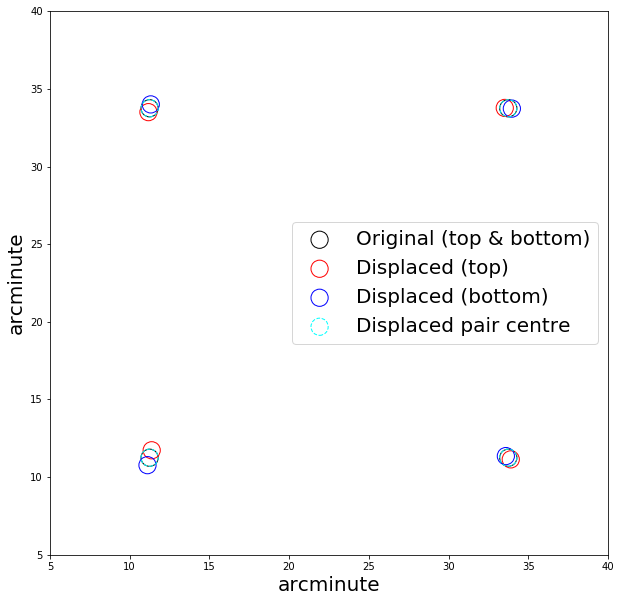

In [6]:
fig = pl.figure(figsize=(10, 10))

liminf = 5
limsup = 40
point2am = (np.max(inst.beam_model.xpos) - np.min(inst.beam_model.xpos))/(10. * fig.dpi)*180./np.pi*60
scale = (np.max(inst.beam_model.xpos) - np.min(inst.beam_model.xpos))*180./np.pi*60 / (limsup - liminf)

pl.scatter(inst.beam_model.xpos[::2]*180./np.pi*60,inst.beam_model.ypos[::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o',
           label='Original (top & bottom)', edgecolors='black')
pl.scatter(inst_mod.beam_model.xpos[::2]*180./np.pi*60,inst_mod.beam_model.ypos[::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o', 
           label='Displaced (top)', edgecolors='red')
pl.scatter(inst_mod.beam_model.xpos[1::2]*180./np.pi*60,inst_mod.beam_model.ypos[1::2]*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o', 
           label='Displaced (bottom)', edgecolors='blue')


pl.scatter(0.5*(inst_mod.beam_model.xpos[1::2]+inst_mod.beam_model.xpos[::2])*180./np.pi*60,0.5*(inst_mod.beam_model.ypos[1::2]+inst_mod.beam_model.ypos[0::2])*180./np.pi*60,
           c='None',alpha=1,s=np.pi*(inst.beam_model.fwhm/point2am)**2*scale,marker='o', 
           label='Displaced pair centre', edgecolors='cyan',ls='--')


pl.xlim(liminf, limsup)
pl.ylim(liminf, limsup)
pl.xlabel('arcminute', fontsize=20)
pl.ylabel('arcminute', fontsize=20)
pl.legend(fontsize=20)
pl.show()

Note that this example is not so realistic as one would need
an input map with higher resolution and smaller deviations (keep in mind we want to displace
things by few arcseconds!). But the code would stay exactly the same in other circumstances!

Note also that you can easily scan an input map at a resolution nside_in, but reconstruct the output map at resolution nside_out != nside_in. For example in Polarbear, to study small pointing effects (differential pointing mismatches are at the arcsecond level), we used to scan an input map with nside_in = 65,536 and reconstruct at nside_out = 2048. 

Beam mismatch approach
=== 

An alternative approach taking into account the finite size and shape of each detector's beam requires the use of the beam mismatch simulation pipeline detailed in the beam ellipticity notebook. Below we detail how to proceed. At the time of writing this notebook some features were only available in the dev branch. If you get errors try compiling that version of the code instead. 

Let's first import some extra modules

In [11]:
from s4cmb.instrument import coordinates_on_grid,gauss2d
from s4cmb.systematics import waferts_add_diffbeam
from s4cmb.systematics import get_kernel_coefficients
from s4cmb.systematics import derivs

Then we need to compute the derivatives of the Stokes paramaters that will be used to propagate the differential 
beam properties (see the [standard](s4cmb_beam_ellipticity.ipynb) ellipticity notebook and its [dev](s4cmb_beam_ellipticity_dev.ipynb) version). 

In [8]:
sky_in.compute_intensity_derivatives(fromalm=False)

Note that you can also read a map of derivatives of the Stokes components from disk. The `synfast` routine and binary of the Healpix suite can be useful for this purpose. We can then display the input sky and its derivatives (for the case of temperature):

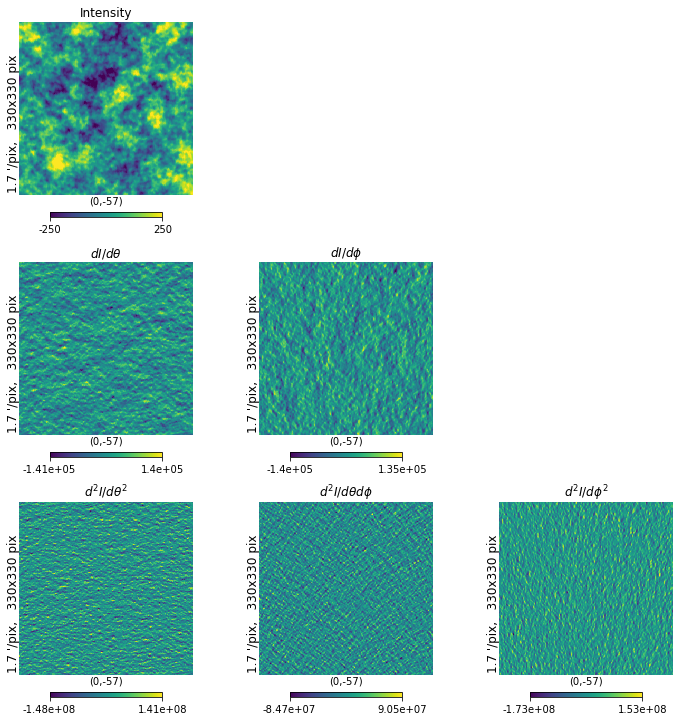

In [9]:

pl.figure(figsize=(10, 10))
hp.gnomview(sky_in.I, rot=[0, -57], 
            xsize=xsize, reso=reso,
            title='Intensity',
            min=-250, max=250, sub=331)
hp.gnomview(sky_in.dIdt, rot=[0, -57], 
            title='$dI/d\\theta$',
            xsize=xsize, reso=reso, sub=334)
hp.gnomview(sky_in.dIdp, rot=[0, -57], 
            title='$dI/d\\phi$',
            xsize=xsize, reso=reso, sub=335)
hp.gnomview(sky_in.d2Id2t, rot=[0, -57], 
            title='$d^2I/d\\theta^2$',
            xsize=xsize, reso=reso, sub=337)
hp.gnomview(sky_in.d2Idpdt, rot=[0, -57], 
            title='$d^2I/d\\theta d\\phi$',
            xsize=xsize, reso=reso, sub=338)
hp.gnomview(sky_in.d2Id2p, rot=[0, -57], 
            title='$d^2I/d\\phi^2$',
            xsize=xsize, reso=reso, sub=339)
pl.show()

### Details of beam expansion

Now we can compute the expansion of the differential beam induced by the differential pointing in terms of the 
derivatives of the Gaussian beam derivatives used to convolve the input map. For comparison we also compute the beam expansion in terms of the effective beam derivatives ("sumbeam")

In [37]:
## Define some useful variables
npair = inst_mod.focal_plane.npair
pair_list = np.reshape(inst_mod.focal_plane.bolo_index_in_fp, (npair, 2))

Ktot = []
Ktot_sum=[]
Ktot_diff=[]
Kptot=[]

## Pre compute leakage runs pair-by-pair 
for pair in pair_list:
    
    ## Compute beam kernel coefficients for both sum and diff beams or only diff beam using
    ## two different basis functions. 
    Ksumdiff = get_kernel_coefficients(inst_mod.beam_model, [pair],nx=200,kernel_type='sumdiff')
    K = get_kernel_coefficients(inst_mod.beam_model, [pair],nx=200,kernel_type='diff',basis='sumbeam')    
    Kplus = get_kernel_coefficients(inst_mod.beam_model, [pair],nx=200,kernel_type='sum',basis='sumbeam')    
    Ktot.append(K)
    Kptot.append(Kplus)
    Ktot_diff.append(Ksumdiff[0])
    Ktot_sum.append(Ksumdiff[1])
    
# convert to array for displaying purposes. 
Ktot = np.array(Ktot)
Ktot_diff = np.array(Ktot_diff)
Ktot_sum = np.array(Ktot_sum)
Kptot = np.array(Kptot)

We can display the statistics of the derivative expansion across the focal plane. As you can see the leakage beam
("Difference beam") inducing I->P and P->I leakage projects mainly on first derivatives (from the figures above is a more 
dipolar structure), while the I->I and P->P leakages projects on the second derivatives and on the monopole itself (causing a loss of power usually corrected through gain calibration). 

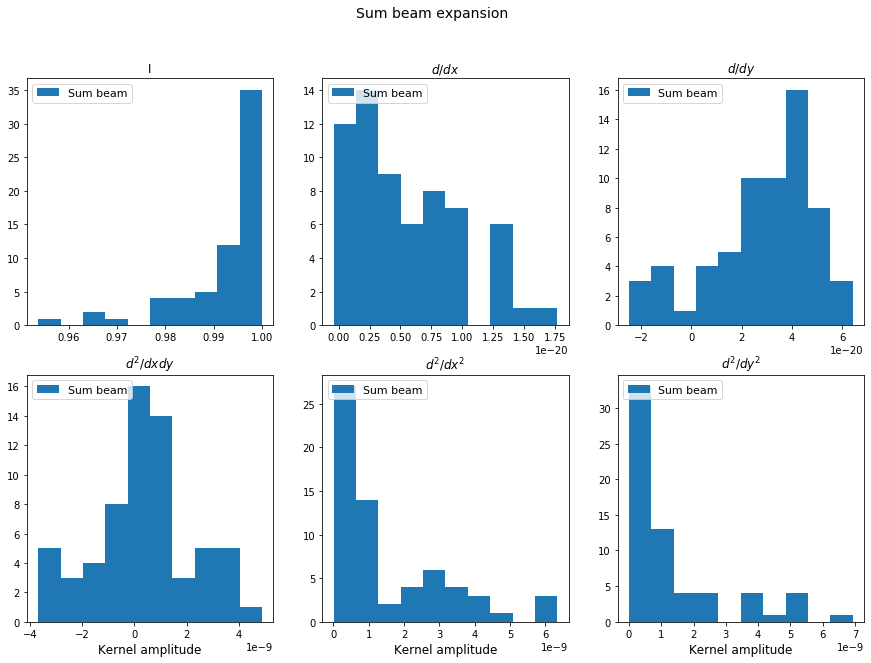

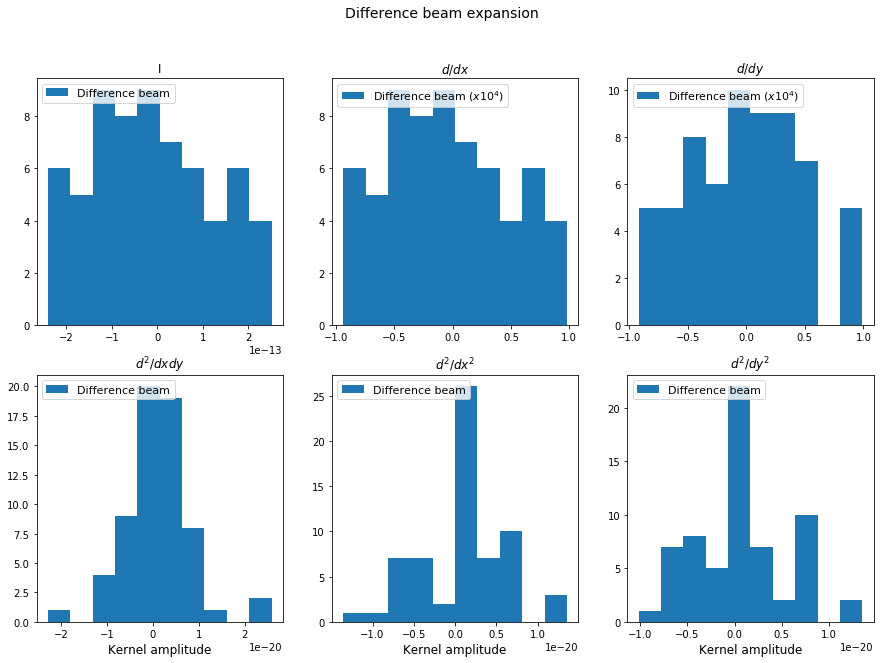

In [38]:
fig,ax = pl.subplots(2,3,figsize=(15,10))
titles=['I','$d/dx$','$d/dy$','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(2):
    for j in range(3):
        ax[i,j].hist(Ktot_sum[:,0,i*3+j],label='Sum beam')
        ax[i,j].legend(loc='upper left',fontsize=11)
        if i==1:ax[i,j].set_xlabel('Kernel amplitude',size=12)
        ax[i,j].set_title(titles[i*3+j],size=12)
fig.suptitle("Sum beam expansion",size=14)
pl.show()


fig,ax = pl.subplots(2,3,figsize=(15,10))
titles=['I','$d/dx$','$d/dy$','$d^2/dxdy$','$d^2/dx^2$','$d^2/dy^2$']
for i in range(2):
    for j in range(3):
        if ((i==0) & (j>0)):
            ax[i,j].hist(Ktot_diff[:,0,i*3+j]*1.0e4,label='Difference beam ($x 10^4$)')
        else:
            ax[i,j].hist(Ktot_diff[:,0,i*3+j],label='Difference beam')
        ax[i,j].legend(loc='upper left',fontsize=11)
        if i==1:ax[i,j].set_xlabel('Kernel amplitude',size=12)
        ax[i,j].set_title(titles[i*3+j],size=12)
fig.suptitle("Difference beam expansion",size=14)

        
pl.show()

We can check how the expansion compares in real space for the sum beam for a subset of detectors. We use here the expansion on the two basis discussed above. An expansion of the beam in terms its derivatives truncated at second order should give an accurate expansion of the beam (this is shown by the sum beam expansion results). A second order expansion in terms of circular approximation of the beam however gives sufficiently precise results. 

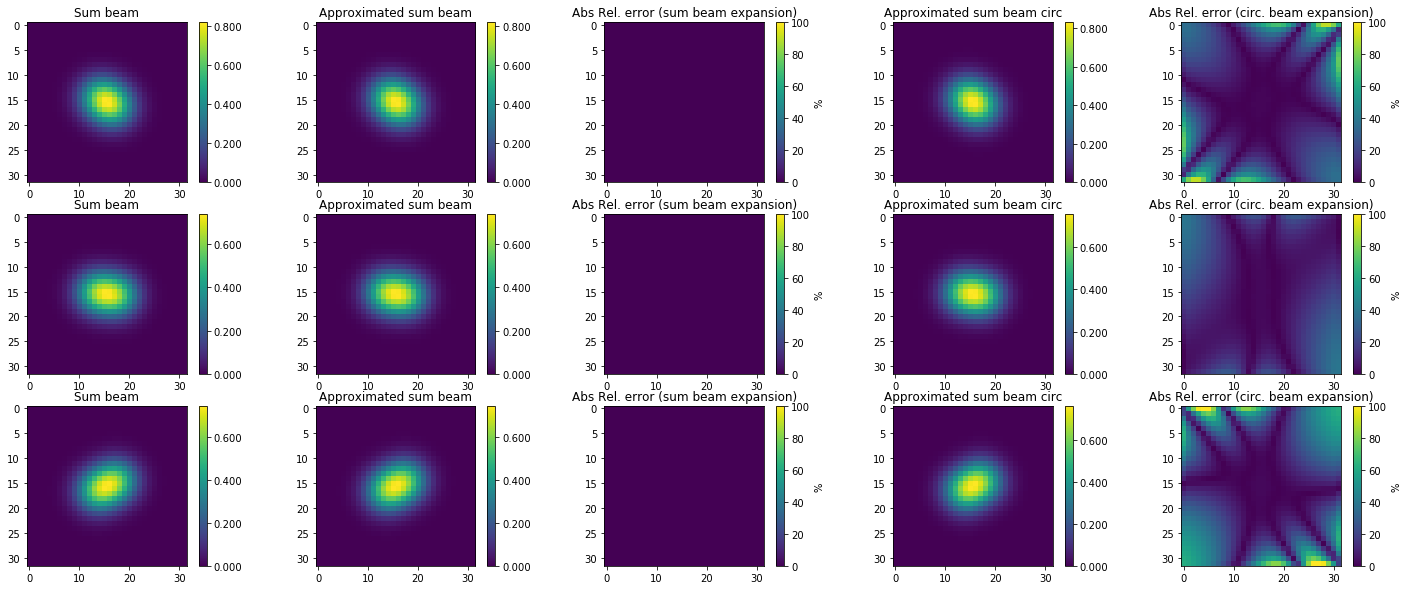

In [40]:
#same useful variables for plotting (pixel size, and beam map width in pixel units, fwhm, coordinates grid etc...)
pix_size = inst_mod.beam_model.fwhm / 7. / 60. * np.pi / 180.
np.seterr(divide='ignore',invalid='ignore')
nx=32

#compute circular beam and its derivative to compare expansions on sumbeam and circular beam approximation
fwhm = inst_mod.beam_model.fwhm*np.pi/180./60
xy2f = coordinates_on_grid(pix_size=pix_size, nx=nx)
circ_beam = gauss2d(xy2f,0,0, 1, fwhm/np.sqrt(8*np.log(2)), fwhm/np.sqrt(8*np.log(2)),0).reshape((nx, nx))
der_circ = derivs(circ_beam, pix_size)
der_circ = der_circ.reshape((6, circ_beam.shape[0] * circ_beam.shape[1]))

fig,ax = pl.subplots(3,5,figsize=(25,10))

for i in range(3):
    detid = 2*i
    summap, diffmap = construct_beammap(inst_mod.beam_model, detid, detid+1, nx, pix_size)
    
    ## Compute sum and diff beam map for the chosen pair
    #summap, diffmap = construct_beammap(inst_mod.beam_model, detid, detid+1, nx, pix_size)
    
    ## Compute derivative of sumbeam 
    der = derivs(summap, pix_size)
    der = der.reshape((6, summap.shape[0] * summap.shape[1]))
    
    ## Compute approximate sum beam using expansion on derivatives of the sum beam 
    ## and relative error w.r.t. to the true sumbeam    
    summap_approx = np.dot(Kptot[i][0], der).reshape((nx, nx))
    rel=(summap - summap_approx)/summap*100 
    
    ## Compute approximate sum beam using expansion on derivatives of the circula Gaussian beam
    ## and relative error w.r.t. to the true sumbeam        
    summap_approx2 = np.dot(Ktot_sum[i][0], der_circ).reshape((nx, nx))
    rel2=(summap - summap_approx2)/summap*100    
    
    obj1 = ax[i, 0].imshow(summap, aspect='equal')
    ax[i, 0].set_title('Sum beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.3f',label='')
    
    obj2 = ax[i, 1].imshow(summap_approx, aspect='equal')
    ax[i, 1].set_title('Approximated sum beam')
    fig.colorbar(obj2, ax=ax[i, 1], orientation='vertical', shrink=1., format='%.3f',label='')
    
    obj3 = ax[i, 2].imshow(np.abs(rel), vmin=0,vmax=100,aspect='equal')
    ax[i,2].set_title('Abs Rel. error (sum beam expansion)')
    fig.colorbar(obj3, ax=ax[i, 2], orientation='vertical', shrink=1., format='%.0f',label='%')

    obj4 = ax[i, 3].imshow(summap_approx2,aspect='equal')#, vmin=np.min(diffmap), vmax=np.max(diffmap), 
    ax[i, 3].set_title('Approximated sum beam circ')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.3f',label='')
    
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Rel. error (circ. beam expansion)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='%')    

pl.show()

We can do the same for the difference beam. Large variation are expected when the beam response is low. The core beam is approximated to ~10% precision with the circular beam approximation that we will use in the following. 

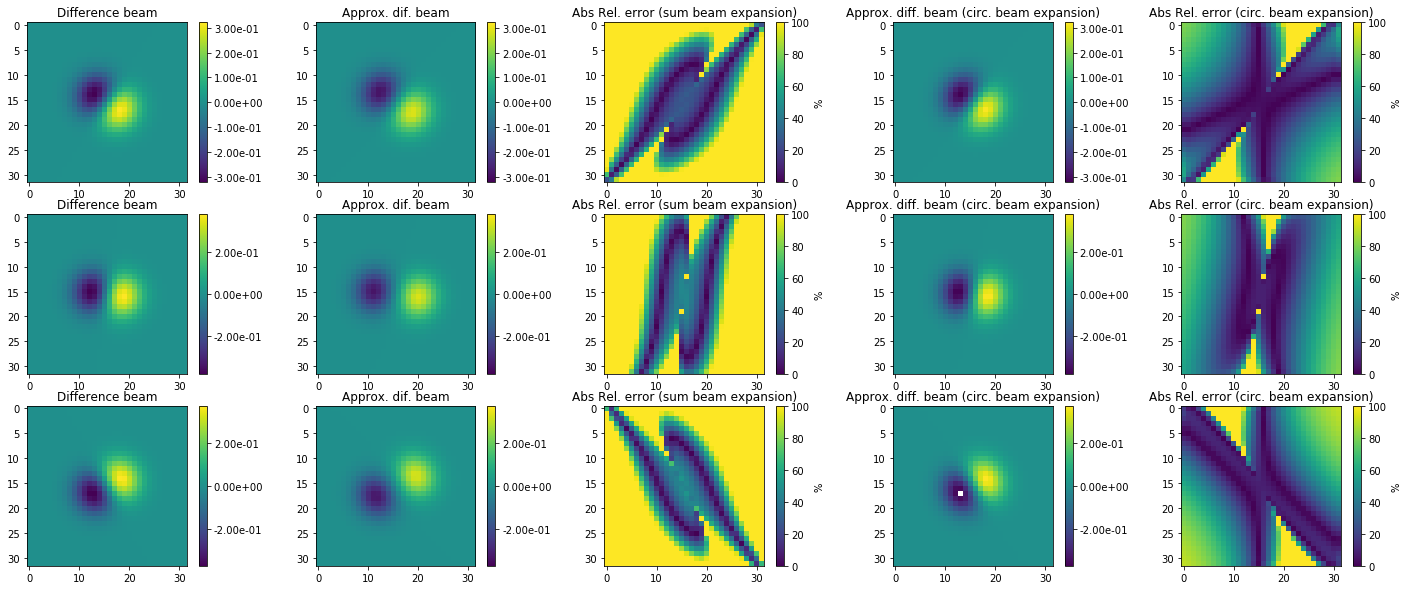

In [45]:
fig,ax = pl.subplots(3,5,figsize=(25,10))
for i in range(3):
    detid = 2*i # pick random detectors in the focalplane
    
    ## Compute sum and diff beam map for the chosen pair
    summap, diffmap = construct_beammap(inst_mod.beam_model, detid, detid+1, nx, pix_size)
    
    ## Compute derivative of sumbeam 
    der = derivs(summap, pix_size)
    der = der.reshape((6, summap.shape[0] * summap.shape[1]))
    
    ## Compute approximate beam using expansion on derivatives on the sum beam 
    ## and relative error w.r.t. to the true diffbeam    
    diffmap_approx = np.dot(Ktot[i][0], der).reshape((nx, nx))
    rel=(diffmap - diffmap_approx)/diffmap*100

    ## Compute approximate diffbeam using expansion on derivatives on the Gaussian circular beam
    ## and relative error w.r.t. to the true diffbeam
    diffmap_approx2 = np.dot(Ktot_diff[i][0], der_circ).reshape((nx, nx))
    rel2=(diffmap - diffmap_approx2)/diffmap*100
    
    obj1 = ax[i, 0].imshow(diffmap, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 0].set_title('Difference beam')
    fig.colorbar(obj1, ax=ax[i, 0],orientation='vertical', shrink=1., format='%.2e')
    
    obj2 = ax[i, 1].imshow(diffmap_approx, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 1].set_title('Approx. dif. beam')
    fig.colorbar(obj2, ax=ax[i, 1],orientation='vertical', shrink=1., format='%.2e')
    
    obj3 = ax[i, 2].imshow(np.abs(rel),vmin=0, vmax=100, aspect='equal')
    ax[i,2].set_title('Abs Rel. error (sum beam expansion)')
    fig.colorbar(obj3, ax=ax[i, 2],orientation='vertical', shrink=1., format='%.0f',label='%')
    
    obj4 = ax[i, 3].imshow(diffmap_approx2, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 3].set_title('Approx. diff. beam (circ. beam expansion)')
    fig.colorbar(obj4, ax=ax[i, 3], orientation='vertical', shrink=1., format='%.2e')
    
    obj5 = ax[i, 4].imshow(np.abs(rel2), vmin=0, vmax=100, aspect='equal')
    ax[i,4].set_title('Abs Rel. error (circ. beam expansion)')
    fig.colorbar(obj5, ax=ax[i, 4], orientation='vertical', shrink=1., format='%.0f',label='%')
    
pl.show()

### Propagating the leakage in the maps 

Here we focus on propagating the leakage effect in the maps. We will include here the main I->P leakage and I->I leakage and do not include the monopole leakage effect in the sum beam to display in more details the effect of the differential pointing alone. This dominates (also visually) and can be removed through calibration. Monopole leakage is subdominant for the I->P and P->I leakage as we saw in the last section.

We will use the beam kernels for a circular beam expansion computed in the previous cells.

In [59]:

for CESnumber in range(scan.nces):
#for CESnumber in range(10):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst_mod, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=20.,
        array_noise_level=None,
        array_noise_seed=None,
        mapping_perpair=True)
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        # ATTENTION derivatives objects used to compute the laakage need to be constructed only for the observed 
        #pixel in the field. 
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        
        ## get I to I
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ktot_sum[i],
            pairlist=pair, 
            spins='012',kernel_type='sum_nomonopole')

        
        # get I to P
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ktot_diff[i],
            pairlist=pair, 
            spins='012',kernel_type='diff_nomonopole')
        
        
        ## Project TOD to maps
        tod.tod2map(d, sky)

We can define some useful plotting routines and display the maps and the residual leakage (to be compared with the leakage computed with the pointing mismatch method, though this one is not strictly equivalent as it includes more details of the beam shape etc. The amplitude however is similar.

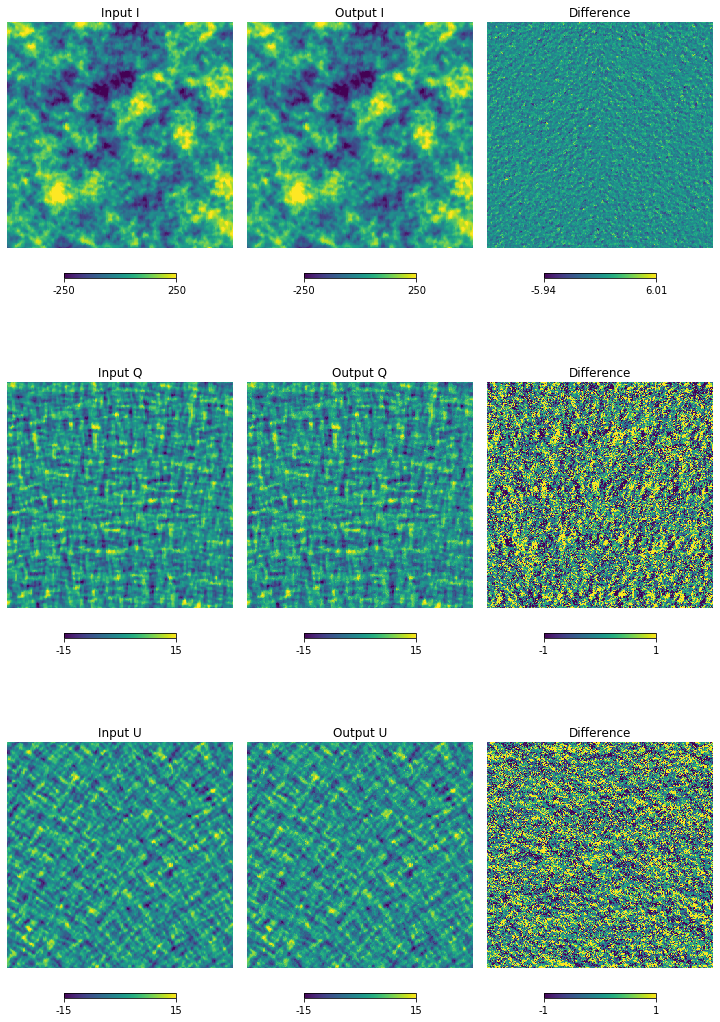

In [62]:
# Define a useful plotting routine and displays results. 
def plot_leakage_maps(sky_in,sky, xsize=700,reso=6.9,xsize_leak=None,rot=[0,-57.5]):
    if xsize_leak is None:
        xsize_leak = xsize
        
    fig = pl.figure(figsize=(10, 15))

    nhit = partial2full(sky.nhit, sky.obspix, sky.nside, fill_with=0.0)
    
    ## Temperature
    sky_out = partial2full(sky.get_I(),sky.obspix,sky.nside, fill_with=0.0)

    mask = nhit < 1
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.I, rot=rot, xsize=xsize, reso=reso, sub=331, 
            title='Input I', notext=True, min=-250, max=250)
    hp.gnomview(sky_out, rot=rot, xsize=xsize, reso=reso, sub=332, 
            title='Output I', notext=True, min=-250, max=250)
    hp.gnomview(sky_in.I - sky_out, rot=rot, 
            xsize=xsize_leak, reso=reso, sub=333, 
            title='Difference', notext=True)

    ## Stokes Q
    sky_out = partial2full(sky.get_QU()[0], sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.Q, rot=rot, xsize=xsize, reso=reso, sub=334, 
            title='Input Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=rot, xsize=xsize, reso=reso, sub=335,  
            title='Output Q',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.Q - sky_out, rot=rot, 
            xsize=xsize_leak, reso=reso, sub=336, 
            notext=True, title='Difference', min=-1, max=1)

    ## Stokes U
    sky_out = partial2full(sky.get_QU()[1],sky.obspix, sky.nside, fill_with=0.0)

    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(sky_in.U, rot=rot, xsize=xsize, reso=reso, sub=337, 
            title='Input U',notext=True, min=-15, max=15)
    hp.gnomview(sky_out, rot=rot, xsize=xsize, reso=reso, sub=338, 
            title='Output U',notext=True, min=-15, max=15)
    hp.gnomview(sky_in.U - sky_out, rot=rot, 
            xsize=xsize_leak, reso=reso, sub=339, 
            title='Difference', notext=True, min=-2, max=2)
    pl.show()
    return

plot_leakage_maps(sky_in,sky, xsize=330,reso=1.7,xsize_leak=330) 

### A quick flat sky test

s4cmb allows also to produce maps using the flat sky projection. Here we show how to run the same pipeline discussed in the previous section using the flat sky projection. 

In order to compare results with and without systematics, we need to project the healpix input map into a flat sky map. The best way to do this accounting for all the projection effects, is to run a map2tod and tod2map cycle using the telescope pointing but without including any systematics. 

Note that to minimize projection artifacts, when using the flat sky projection the pointing is rotated so that the telescope scans a patch whose centre is set in (0,0). Because of this a direct comparison between Healpix and flat map cannot be done on the map level. 

In [89]:
# Create flat sky map without systematics. Here we map all the detectors right away setting mapping_perpair=True.
for CESnumber in range(scan.nces):
    tod_nosys = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='flat', 
        nside_out=nside, 
        width=9.35,
        array_noise_level=None,
        array_noise_seed=None,
        mapping_perpair=True,pixel_size=2)

    ## Initialise map containers
    if CESnumber == 0:
        sky_nosys = OutputSkyMap(
            projection=tod_nosys.projection, 
            nside=tod_nosys.nside_out, 
            obspix=tod_nosys.obspix,npixsky=tod_nosys.npixsky,pixel_size=tod_nosys.pixel_size)
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod_nosys.pair_list)):
        ## Get the TOD
        d = np.array([tod_nosys.map2tod(det) for det in pair])  
        ## Project TOD to maps
        tod_nosys.tod2map(d, sky_nosys)

In order to include the beam leakages, now you have to proceed as in the original case with a few caveats:
* In the TimeOrderedDataPairDiff class you need to set `store_pointing_matrix_input=True`. This is required as we need to re-inject the leakage a posteriori modifying the timestreams created by map2tod. The tod class will then acquire a new input object `point_matrix_input` that contains the pointing matrix adopting the Healpix full-sky pixel indexing scheme (this is redundant in the Healpix case but required in the flat projection as we will reproject tod in a different pixelization than the one of the input map).
* call `waferts_add_diffbeam` using the derivatives vector including the full sky maps instead of a vector including only the observed pixels. 
* call `waferts_add_diffbeam` with `point_matrix=tod.point_matrix_input` instead of `point_matrix=tod.point_matrix`. 


In [90]:
for CESnumber in range(scan.nces):
## ATTENTION note the store_pointing_matrix_input argument.
    tod = TimeOrderedDataPairDiff(
        inst_mod, scan, sky_in, CESnumber=CESnumber, 
        projection='flat', 
        nside_out=nside, 
        width=9.35,
        array_noise_level=None,
        array_noise_seed=None,
        mapping_perpair=True,pixel_size=2,store_pointing_matrix_input=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix,npixsky=tod.npixsky,pixel_size=tod.pixel_size)
        
        # ATTENTION derivatives objects need to be constructed for the full sky when using the flat sky 
        # projection.  
        intensity_derivatives = np.array(
            [sky_in.I, sky_in.dIdt, sky_in.dIdp, 
             sky_in.d2Idpdt, sky_in.d2Id2t, sky_in.d2Id2p])
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for i,pair in enumerate(tqdm(tod.pair_list)):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
                
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        # get I->I
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix_input, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ktot_sum[i],
            pairlist=pair, 
            spins='012',kernel_type='sum_nomonopole')

        
        # get I->P
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix_input, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=Ktot_diff[i],
            pairlist=pair, 
            spins='012',kernel_type='diff_nomonopole')
                
        ## Project TOD to maps
        tod.tod2map(d, sky)

We can now plot the results. As you can see the flat sky reconstructed map agrees with the relevant patch of the full sky input map. Though we cannot directly compare with the full sky result since we are not scanning the same region of the sky, a similar magnitude of the effect is observed. 

<Figure size 432x288 with 0 Axes>

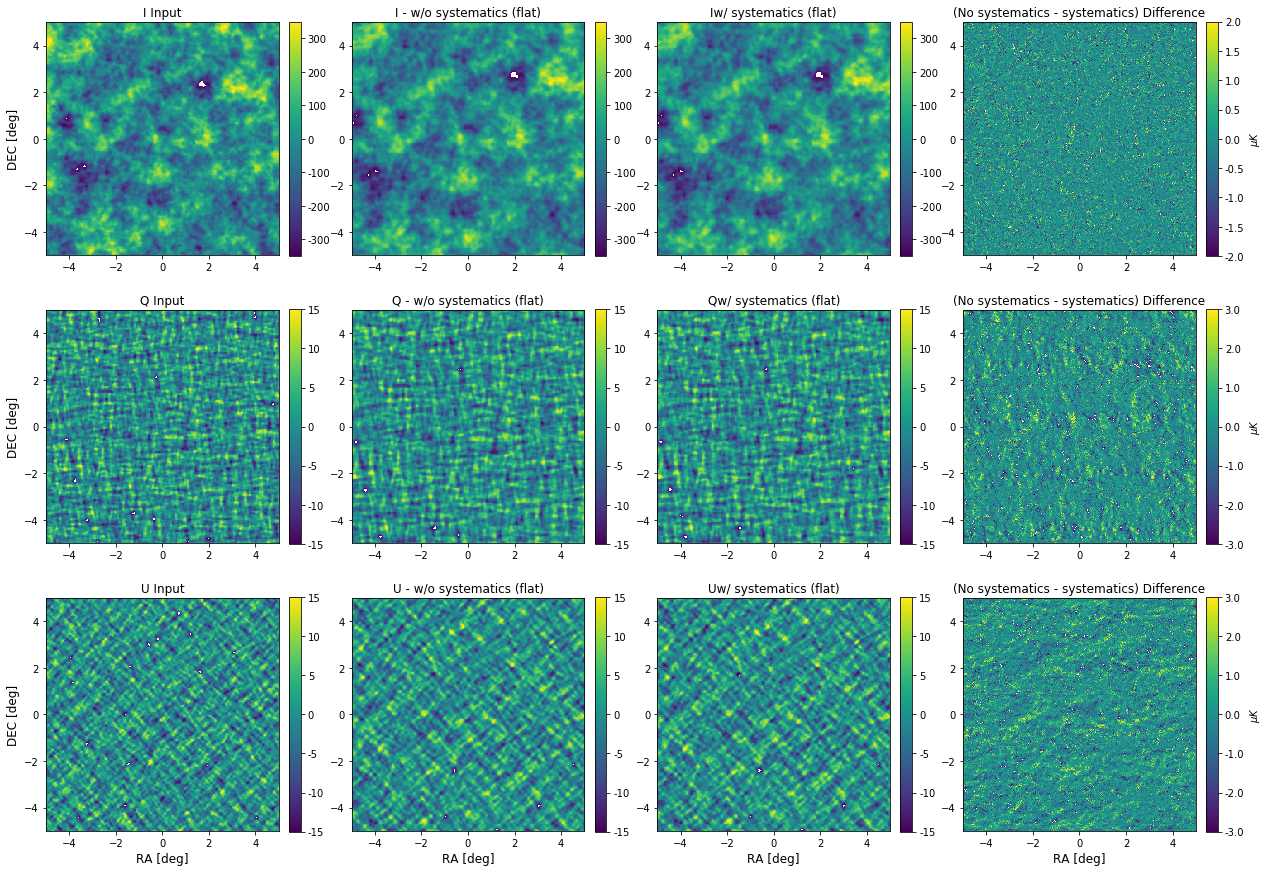

In [146]:
Ino = sky_nosys.get_I()
I = sky.get_I()
nx = int(np.sqrt(len(I)))

QUno = sky_nosys.get_QU(force=True)
QU = sky.get_QU(force=True)

# Project input full sky map Healpix as flat-sky patch usign the azimuthal equal area Lambert projection
i_healpix = hp.azeqview(sky_in.I, xsize=330, reso=2,title='Healpix input I', min=-350, max=350, sub=131,notext=True,flip='geo',return_projected_map=True,lamb=True)
q_healpix = hp.azeqview(sky_in.Q, xsize=330, reso=2,title='Healpix input Q',min=-15, max=15, sub=132,notext=True,flip='geo',return_projected_map=True,lamb=True)
u_healpix = hp.azeqview(sky_in.U, xsize=330, reso=2,title='Healpix iInput U',min=-15, max=15, sub=133,notext=True,flip='geo',return_projected_map=True,lamb=True)

pl.clf()
fig,ax = pl.subplots(3,4,figsize=(21,15))

obj00=ax[0,0].imshow(i_healpix,origin='lower',vmin=-350,vmax=350,extent=(-5,5,-5,5))
obj01=ax[0,1].imshow(Ino.reshape(nx,nx).T,origin='lower',vmin=-350,vmax=350,extent=(-5,5,-5,5))
obj02=ax[0,2].imshow(I.reshape(nx,nx).T,origin='lower',vmin=-350,vmax=350,extent=(-5,5,-5,5))
obj1=ax[0,3].imshow((Ino-I).reshape(nx,nx).T,origin='lower',vmin=-2,vmax=2,extent=(-5,5,-5,5))
fig.colorbar(obj00, ax=ax[0, 0],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj01, ax=ax[0, 1],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj02, ax=ax[0, 2],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj1, ax=ax[0, 3],orientation='vertical', shrink=1., format='%.1f',label='$\mu K$',fraction=0.046, pad=0.04)


obj10=ax[1,0].imshow(q_healpix,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj11=ax[1,1].imshow(QUno[0].reshape(nx,nx).T,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj12=ax[1,2].imshow(QU[0].reshape(nx,nx).T,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj2=ax[1,3].imshow((QUno[0]-QU[0]).reshape(nx,nx).T,origin='lower',vmin=-3,vmax=3,extent=(-5,5,-5,5))
fig.colorbar(obj10, ax=ax[1, 0],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj11, ax=ax[1, 1],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj12, ax=ax[1, 2],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj2, ax=ax[1, 3],orientation='vertical', shrink=1., format='%.1f',label='$\mu K$',fraction=0.046, pad=0.04)

obj20=ax[2,0].imshow(u_healpix,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj21=ax[2,1].imshow(QUno[1].reshape(nx,nx).T,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj22=ax[2,2].imshow(QU[1].reshape(nx,nx).T,origin='lower',vmin=-15,vmax=15,extent=(-5,5,-5,5))
obj3=ax[2,3].imshow((QUno[1]-QU[1]).reshape(nx,nx).T,origin='lower',vmin=-3,vmax=3,extent=(-5,5,-5,5))
fig.colorbar(obj20, ax=ax[2, 0],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj21, ax=ax[2, 1],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj22, ax=ax[2, 2],orientation='vertical', shrink=1., format='%.0f',label='',fraction=0.046, pad=0.04)
fig.colorbar(obj3, ax=ax[2, 3],orientation='vertical', shrink=1., format='%.1f',label='$\mu K$',fraction=0.046, pad=0.04)

stokes=['I','Q','U']
maptype=[' Input',' - w/o systematics (flat)','w/ systematics (flat)','(No systematics - systematics) Difference']
for i in range(3):
    for j in range(4):
        if i==2:
            ax[i,j].set_xlabel('RA [deg]',size=12)
        if j==0:
            ax[i,j].set_ylabel('DEC [deg]',size=12)
        if j==3:
            ax[i,j].set_title(maptype[j],size=12)
        else:
            ax[i,j].set_title(stokes[i]+maptype[j],size=12)
            
pl.show()
